In [1]:
from google.colab import drive
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
import cv2
from mpl_toolkits.mplot3d import Axes3D
from tqdm import tqdm

# Import data from drive
drive.mount('/content/drive')
mat_file_path = '/content/drive/MyDrive/dataset/2024_2025_RAUS_dataset_arc/images_test3/frame_axes_data_20241216_2.mat'
data = scipy.io.loadmat(mat_file_path)
data_matrix = data['data_matrix']

# positions : positions buffer of ultrasound probe for each image
positions = data_matrix[:120, 9:12]
# x_vectors, y_vectors, z_vectors : vectors buffer of each plane
x_vectors = data_matrix[:120, 0:3]
y_vectors = data_matrix[:120, 3:6]
z_vectors = data_matrix[:120, 6:9]

# Calculate the center position in 3D frame (X, Y)
X_mean = np.mean([np.max(positions[:, 0]), np.min(positions[:, 0])])
Y_mean = np.mean([np.max(positions[:, 1]), np.min(positions[:, 1])])

# Calculate the highest position in 3D frame (Z)
Z_max = np.max(positions[:, 2])

print(X_mean)
print(Y_mean)
print(Z_max)

plane_equations = []

# Generate buffer that express plane equation of each plane
for i in range(len(positions)):

    a, b, c = z_vectors[i]
    x0, y0, z0 = positions[i]
    d = a * x0 + b * y0 + c * z0

    plane_equations.append((a, b, c, d))

# Image template for importing images
bscan_image_template = '/content/drive/MyDrive/dataset/2024_2025_RAUS_dataset_arc/images_test3/{}_bmode.png'

# Calculate range x, y, z range using X_mean, Y_mean, and Z_max
x_range = (X_mean - 0.012, X_mean + 0.013)
y_range = (Y_mean - 0.010, Y_mean + 0.010)
z_range = (Z_max - 0.030, Z_max)

# Generate query points using linspace function
x = np.linspace(*x_range, int(50 * 18.0) )
y = np.linspace(*y_range, int(40 * 18.0) )
z = np.linspace(*z_range, int(60 * 18.0) )

distances = []
projections = []
plane_images = []

# Generate plane_images by importing B-scan images
for idx in tqdm(range(len(plane_equations)), desc="Processing"):
    bscan_image_path = bscan_image_template.format(idx)

    image = cv2.imread(bscan_image_path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        raise FileNotFoundError(f"Image not found at path: {bscan_image_path}")

    plane_images.append(image)

len_pxl_width = 371
len_pxl_height = 1083
len_mm_width = 25.0
len_mm_height = 30.0
ratio_of_width = len_mm_width / len_pxl_width / 1000  # width (m) per pixel
ratio_of_height = len_mm_height / len_pxl_height / 1000  # height (m) per pixel

interpolated_intensities = []

Mounted at /content/drive
0.29704598735568455
0.10757069163438071
0.03955516941874149


Processing: 100%|██████████| 120/120 [00:44<00:00,  2.67it/s]


In [2]:
import numpy as np
from tqdm import tqdm

plane_origins = positions
plane_normals = z_vectors
print(f"plane origins: {plane_origins.shape}")
print(f"plane normals: {plane_normals.shape}")

# Transpose query_points to move the x, y, z components to the last axis
query_points = np.array(np.meshgrid(x, y, z, indexing='ij')).transpose(1, 2, 3, 0)
print(f"query_points (transposed): {query_points.shape}")

# Initialize arrays to track only the top two distances and plane indices (best_val1 : Closest distance, best_val2 : Second closest distance, best_idx1 : Index of closest plane, best_idx2 : Index of second closest plane)
best_val1 = np.full(query_points.shape[:-1], np.inf, dtype=query_points.dtype)
best_idx1 = np.full(query_points.shape[:-1], -1,   dtype=int)
best_val2 = np.full(query_points.shape[:-1], np.inf, dtype=query_points.dtype)
best_idx2 = np.full(query_points.shape[:-1], -1,   dtype=int)

# Compute distances plane-by-plane
for i in tqdm(range(plane_origins.shape[0]), desc="Processing"):
    # Signed distance from plane i to all (x,y,z) in query_points
    distance_i = (
          (query_points[..., 0] - plane_origins[i, 0]) * plane_normals[i, 0]
        + (query_points[..., 1] - plane_origins[i, 1]) * plane_normals[i, 1]
        + (query_points[..., 2] - plane_origins[i, 2]) * plane_normals[i, 2]
    )
    abs_distance_i = np.abs(distance_i)

    # Check if abs_distance_i beats the current #1 best distance
    mask1 = abs_distance_i < best_val1

    # Put abs_distance into new #1 and old #1 into #2 where mask1 is True (abs_distance -> New #1, Old #1 -> New #2)
    new_best_val2 = np.where(mask1, best_val1, best_val2)
    new_best_idx2 = np.where(mask1, best_idx1, best_idx2)
    new_best_val1 = np.where(mask1, abs_distance_i, best_val1)
    new_best_idx1 = np.where(mask1, i, best_idx1)

    # Among those not improved by mask1, see if abs_distance_i beats #2
    mask2 = (~mask1) & (abs_distance_i < new_best_val2)

    # Put abs_distance into new #2
    final_best_val2 = np.where(mask2, abs_distance_i, new_best_val2)
    final_best_idx2 = np.where(mask2, i, new_best_idx2)

    # Update the best and second-best holders
    best_val1 = new_best_val1
    best_idx1 = new_best_idx1
    best_val2 = final_best_val2
    best_idx2 = final_best_idx2

# Stack the plane indices of the two closest planes:
closest_planes = np.stack((best_idx1, best_idx2), axis=0)
print("closest_planes shape:", closest_planes.shape)

print("distances1 shape:", best_val1.shape)
print("distances2 shape:", best_val2.shape)


plane origins: (120, 3)
plane normals: (120, 3)
query_points (transposed): (900, 720, 1080, 3)


Processing: 100%|██████████| 120/120 [48:50<00:00, 24.42s/it]


closest_planes shape: (2, 900, 720, 1080)
distances1 shape: (900, 720, 1080)
distances2 shape: (900, 720, 1080)


In [3]:
# Delete buffers that are not used anymore.

del best_idx1, best_idx2, new_best_val1, new_best_idx1, new_best_val2, new_best_idx2, mask1, mask2, final_best_val2, final_best_idx2, distance_i, abs_distance_i, data, data_matrix, positions, z_vectors

import gc
gc.collect()

3

In [4]:
import numpy as np

# Cast plane indices to int16 (Memory Capacity)
first_closest_plane_indices = closest_planes[0, ...].astype(np.int16)
second_closest_plane_indices = closest_planes[1, ...].astype(np.int16)

print(f"first_closest_plane_indices: {first_closest_plane_indices.shape}, dtype={first_closest_plane_indices.dtype}")
print(f"second_closest_plane_indices: {second_closest_plane_indices.shape}, dtype={second_closest_plane_indices.dtype}")

# Cast positions / x_vectors / y_vectors to float16 if not already (Memory Capacity)
positions = plane_origins.astype(np.float16)
x_vectors = x_vectors.astype(np.float16)
y_vectors = y_vectors.astype(np.float16)
query_points = query_points.astype(np.float16)

# Extract origins,x_vectors, y_vectors of the closest planes for all grid points (Memory Capacity)
origins1 = positions[first_closest_plane_indices].astype(np.float16)
x_vectors1 = x_vectors[first_closest_plane_indices].astype(np.float16)
y_vectors1 = y_vectors[first_closest_plane_indices].astype(np.float16)

print(f"origins1: {origins1.shape}, dtype={origins1.dtype}")
print(f"x_vectors1: {x_vectors1.shape}, dtype={x_vectors1.dtype}")
print(f"y_vectors1: {y_vectors1.shape}, dtype={y_vectors1.dtype}")

# Extract origins,x_vectors, y_vectors of the second closest planes for all grid points (Memory Capacity)
origins2 = positions[second_closest_plane_indices].astype(np.float16)
x_vectors2 = x_vectors[second_closest_plane_indices].astype(np.float16)
y_vectors2 = y_vectors[second_closest_plane_indices].astype(np.float16)

# Calculate vector `v` from the origin to the query point
v1 = (query_points - origins1).astype(np.float16)  # shape (A,B,C,3)
v2 = (query_points - origins2).astype(np.float16)  # shape (A,B,C,3)

print(f"v1: {v1.shape}, dtype={v1.dtype}")
print(f"v2: {v2.shape}, dtype={v2.dtype}")

# Compute the projections on X and Y axes of two planes for all the query points (dot products)
v_x1 = np.sum((v1 * x_vectors1).astype(np.float16), axis=-1).astype(np.float16)
v_y1 = np.sum((v1 * y_vectors1).astype(np.float16), axis=-1).astype(np.float16)
print(f"v_x1: {v_x1.shape}, dtype={v_x1.dtype}")
print(f"v_y1: {v_y1.shape}, dtype={v_y1.dtype}")

v_x2 = np.sum((v2 * x_vectors2).astype(np.float16), axis=-1).astype(np.float16)
v_y2 = np.sum((v2 * y_vectors2).astype(np.float16), axis=-1).astype(np.float16)

# Convert ratio_of_width / ratio_of_height to float16 for consistency
ratio_of_height = np.float16(ratio_of_height)
ratio_of_width  = np.float16(ratio_of_width)

# Map to pixel coordinates
pixel_y1 = (v_x1 / ratio_of_height).astype(np.float16)
pixel_x1 = (v_y1 / ratio_of_width).astype(np.float16)

pixel_y2 = (v_x2 / ratio_of_height).astype(np.float16)
pixel_x2 = (v_y2 / ratio_of_width).astype(np.float16)

# Center pixels (also cast len_pxl_width / len_pxl_height to float16 if large enough)
len_pxl_width  = np.int16(len_pxl_width)
len_pxl_height = np.int16(len_pxl_height)

# Adjust x and y coordinates
pixel_x_centered1 = (pixel_x1 + (len_pxl_width / 2)).astype(np.float16)
pixel_y_centered1 = pixel_y1

pixel_x_centered2 = (pixel_x2 + (len_pxl_width / 2)).astype(np.float16)
pixel_y_centered2 = pixel_y2

# Clamp pixel values to valid ranges
# Here we clamp to int16 as well (assuming the image size < 32767)
pixel_x_clamped1 = np.clip(pixel_x_centered1, 0, len_pxl_width - 1).astype(np.int16)
pixel_y_clamped1 = np.clip(pixel_y_centered1, 0, len_pxl_height - 1).astype(np.int16)

print(f"pixel_x_clamped1: {pixel_x_clamped1.shape}, dtype={pixel_x_clamped1.dtype}")
print(f"pixel_y_clamped1: {pixel_y_clamped1.shape}, dtype={pixel_y_clamped1.dtype}")

pixel_x_clamped2 = np.clip(pixel_x_centered2, 0, len_pxl_width - 1).astype(np.int16)
pixel_y_clamped2 = np.clip(pixel_y_centered2, 0, len_pxl_height - 1).astype(np.int16)


first_closest_plane_indices: (900, 720, 1080), dtype=int16
second_closest_plane_indices: (900, 720, 1080), dtype=int16
origins1: (900, 720, 1080, 3), dtype=float16
x_vectors1: (900, 720, 1080, 3), dtype=float16
y_vectors1: (900, 720, 1080, 3), dtype=float16
v1: (900, 720, 1080, 3), dtype=float16
v2: (900, 720, 1080, 3), dtype=float16
v_x1: (900, 720, 1080), dtype=float16
v_y1: (900, 720, 1080), dtype=float16
pixel_x_clamped1: (900, 720, 1080), dtype=int16
pixel_y_clamped1: (900, 720, 1080), dtype=int16


In [6]:
# Delete buffers that are not used anymore.

del v1, v2, v_x1, v_y1, v_x2, v_y2, pixel_x_centered1, pixel_x_centered2, pixel_y_centered1, pixel_y_centered2, pixel_x1, pixel_y1, pixel_x2, pixel_y2, x_vectors1, x_vectors2, y_vectors1, y_vectors2, origins1, origins2

import gc
gc.collect()

NameError: name 'v1' is not defined

In [7]:
import numpy as np

plane_images = np.array(plane_images)  # Convert list to NumPy array
print(plane_images.shape)

# Generate grid indices for dimensions
grid_x, grid_y, grid_z = np.meshgrid(
    np.arange(first_closest_plane_indices.shape[0]),
    np.arange(first_closest_plane_indices.shape[1]),
    np.arange(first_closest_plane_indices.shape[2]),
    indexing="ij",
)

# Extract intensities for the two closest planes
intensities1 = plane_images[
    first_closest_plane_indices,
    pixel_y_clamped1,
    pixel_x_clamped1,
]
intensities2 = plane_images[
    second_closest_plane_indices,
    pixel_y_clamped2,
    pixel_x_clamped2,
]

print(intensities1.shape)
print(intensities2.shape)

(120, 1083, 371)
(900, 720, 1080)
(900, 720, 1080)


In [8]:
del first_closest_plane_indices, second_closest_plane_indices, pixel_x_clamped1, pixel_x_clamped2, pixel_y_clamped1, pixel_y_clamped2
import gc
gc.collect()

0

In [9]:
# Calculate weights for interpolation
weight1 = 1 / best_val1 / (1 / best_val1 + 1 / best_val2)
weight2 = 1 / best_val2 / (1 / best_val1 + 1 / best_val2)

# Perform weighted interpolation
interpolated_intensity = weight1 * intensities1 + weight2 * intensities2
print(interpolated_intensity.shape)

(900, 720, 1080)


In [10]:
del weight1, weight2, intensities1, intensities2
import gc
gc.collect()

0

In [11]:
# Distance for plane 0
distance_0 = (
    (query_points[..., 0] - plane_origins[0, 0]) * plane_normals[0, 0] +
    (query_points[..., 1] - plane_origins[0, 1]) * plane_normals[0, 1] +
    (query_points[..., 2] - plane_origins[0, 2]) * plane_normals[0, 2]
)

# Distance for plane -1 (the last plane)
distance_last = (
    (query_points[..., 0] - plane_origins[-1, 0]) * plane_normals[-1, 0] +
    (query_points[..., 1] - plane_origins[-1, 1]) * plane_normals[-1, 1] +
    (query_points[..., 2] - plane_origins[-1, 2]) * plane_normals[-1, 2]
)

# Mask for determining valid pixels
valid = (distance_0 < 0) & (distance_last > 0)
print("valid shape:", valid.shape)

# Generate masked_intensity
masked_intensity = np.where(valid, interpolated_intensity, 0)

valid shape: (900, 720, 1080)


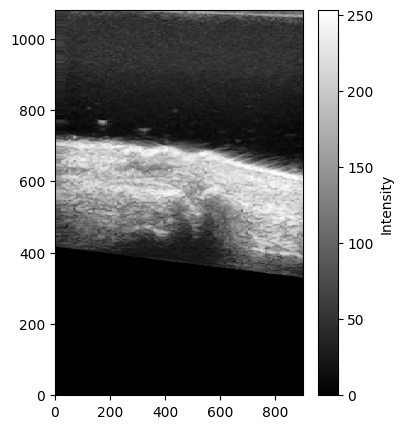

In [12]:
import numpy as np
import matplotlib.pyplot as plt

# Rotate the slice 90 degrees counterclockwise
rotated_intensity = np.rot90(masked_intensity[:, 360, :], k = -1)

plt.figure(figsize=(4, 5))
plt.imshow(rotated_intensity, cmap='gray', origin='lower', aspect='auto')
plt.colorbar(label="Intensity")
plt.show()


In [13]:
np.save("interpolated_intensity_CPU_20240101.npy", interpolated_intensity)